# Results

## load

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import helpers as hlp
import matplotlib.pyplot as plt

mystore = r'C:\Daten\_tmp\FRdata.h5'
reader = hlp.H5Reader2()

gr_palette = {'Male-Caucasian':'blue', 
           'Female-Caucasian':'deepskyblue', 
           'Male-Indian':'green',       
           'Female-Indian':'lime',
           'Male-Asian':'darkorange', 
           'Female-Asian':'gold', 
           'Male-African':'maroon',
           'Female-African':'red'}

## Statistics

In [24]:
_, df = reader.read('VGG128')
tmp = (df.groupby(['race','gender']).count()[['subject']]
       .reset_index()
       .pivot(index='gender',columns='race',values='subject')  )
print(tmp.to_latex())

\begin{tabular}{lrrrr}
\toprule
race &  Caucasian &  Indian &  Asian &  African \\
gender &            &         &        &          \\
\midrule
Female &       3178 &    2802 &   3955 &      344 \\
Male   &       6921 &    7419 &   5647 &    10053 \\
\bottomrule
\end{tabular}



In [31]:
np.sum(tmp.values)

40319

In [23]:
print(df.groupby(['gender']).count()[['subject']])

        subject
gender         
Female    10279
Male      30040


## t-SNE

Introduce the story with a t-SNE plot. A lot of things can be explained ...

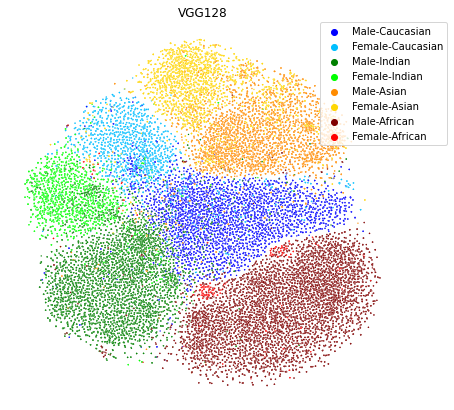

In [211]:
def plot_tSNE(df, title):
    df['Gender-Ethnicity'] = df.gender + '-' + df.race
    fig = plt.figure(figsize=[7,7])
    g = sns.scatterplot(data=df,x='x',y='y',hue='Gender-Ethnicity',hue_order=gr_palette.keys(),
                        legend=True,s=2,palette=gr_palette)
    plt.title(title)
    plt.axis('off')
    plt.legend(bbox_to_anchor=(0.8, 1), loc=2, borderaxespad=0.)
    plt.show()
    return fig

fig = plot_tSNE(pd.read_hdf(mystore,'t_SNE_vgg128'), 'VGG128')
fig.savefig("latex/t-SNE_vgg128.png",bbox_inches='tight')

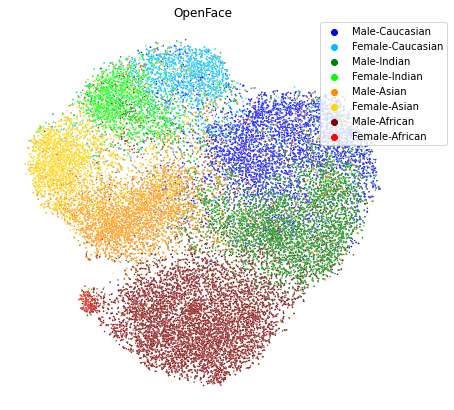

In [212]:
fig = plot_tSNE(pd.read_hdf(mystore,'t_SNE_openface'), 'OpenFace')
fig.savefig("latex/t-SNE_openface.png",bbox_inches='tight')

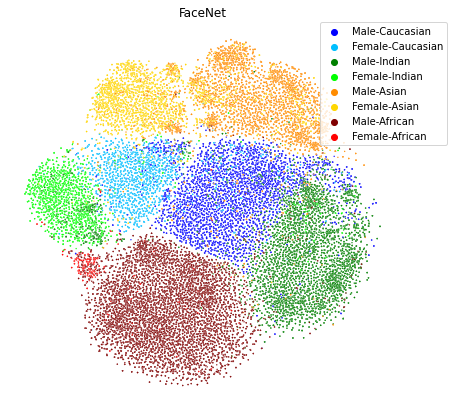

In [213]:
fig = plot_tSNE(pd.read_hdf(mystore,'t_SNE_FaceNet'), 'FaceNet')
fig.savefig("latex/t-SNE_facenet.png",bbox_inches='tight')

## Awareness

1. Illustrate that the high dimensional space is structured by simple convex clusters
2. Blinding - to be seen

In [221]:
def calc_score(df, metric, yr, yg, ya):
    out = pd.DataFrame(index=df.columns)
    y_dict = {'r':yr, 'g':yg, 'a':ya}
    for col in df.columns:
        y_true = y_dict[col.split('-')[-1]]
        y_pred = df[col].values
        sel = np.isfinite(y_true)
        # out.loc[col,'Score'] = accuracy_score(y_true[sel],y_pred[sel])
        out.loc[col,'Score'] = metric(y_true[sel],y_pred[sel],average='macro')
    out = out.reset_index().rename(columns={'index':'Key'})
    out.head()
    
    model_label = lambda s, ind:{'128':'128','256':'256','ft':'2048','FaceNet':'FaceNet','OpenFace':'OpenFace'}[s.split('-')[ind]]
    blinding_label = lambda s, ind:{'n':'None','r':'Ethnicity','g':'Gender','rg':'Ethn.+Gend.'}[s.split('-')[ind]]
    dist_label = lambda s, ind:{'e':'Eucl.','c':'Cosine'}[s.split('-')[ind]]
    group_label = lambda s, ind:{'r':'Ethnicity','g':'Gender','a':'Age'}[s.split('-')[ind]]
    classifier_label = lambda s, ind:s.split('-')[ind]

    out['Classifier'] = out['Key'].apply(classifier_label,args=[0])
    out['Model'] = out['Key'].apply(model_label,args=[1])
    out['Blinding'] = out['Key'].apply(blinding_label,args=[2])
    out['Dist. Measure'] = out['Key'].apply(dist_label,args=[3])
    out['Group'] = out['Key'].apply(group_label,args=[4])
    
    return out

# loading the data
from sklearn.metrics import f1_score, accuracy_score

reader = hlp.H5Reader2()
_, df = reader.read('VGG128')
yr = df.race.cat.codes.values
yg = 1-df.gender.cat.codes.values
ya = df.age.cat.codes.values
df = pd.read_hdf(mystore,'clf_predict_indices')
sdf = calc_score(df, f1_score, yr, yg, ya)
sdf.head()

,Key,Score,Classifier,Model,Blinding,Dist. Measure,Group
0,Logit-128-n-e-r,0.962336,Logit,128,None,Eucl.,Ethnicity
1,Logit-128-n-e-g,0.907653,Logit,128,None,Eucl.,Gender
2,Logit-128-n-e-a,0.503217,Logit,128,None,Eucl.,Age
3,KNN5-128-n-e-r,0.943368,KNN5,128,None,Eucl.,Ethnicity
4,KNN5-128-n-e-g,0.879598,KNN5,128,None,Eucl.,Gender


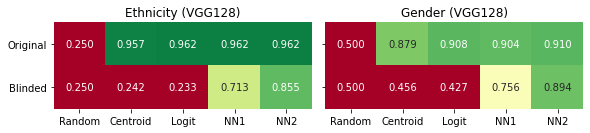

In [223]:
def plot_awareness(df, title, model, cols = ['Centroid','Logit','NN1','NN2'], cmap='RdYlGn'):
    fig, axs = plt.subplots(ncols=2, sharey=True,figsize=(8,2))
    plt.subplots_adjust(top=0.8,bottom=0.2,left=0.08,wspace=0.05,right=1)

    sel = (df.Model==model) & (df.Group=='Ethnicity') & df.Blinding.isin(['None','Ethnicity']) & (df['Dist. Measure'] == 'Eucl.')
    tmp = (df[sel].pivot(index='Blinding',columns='Classifier',values='Score')[cols]
           .sort_values(by='Blinding',ascending=False) )
    tmp.insert(0,'Random',0.25)
    g = sns.heatmap(tmp,cmap=cmap,annot=True,cbar=False,fmt='.3f',vmin=0.25,vmax=1,ax=axs[0])
    g.set(xlabel=None)
    g.set(ylabel=None)
    g.set_title('Ethnicity ({})'.format(title))
    g.set_yticklabels(['Original','Blinded'],rotation=0)

    sel = (df.Model==model) & (df.Group=='Gender') & df.Blinding.isin(['None','Gender']) & (df['Dist. Measure'] == 'Eucl.')
    tmp = (df[sel].pivot(index='Blinding',columns='Classifier',values='Score')[cols]
           .sort_values(by='Blinding',ascending=False) )
    tmp.insert(0,'Random',0.5)
    g = sns.heatmap(tmp,cmap=cmap,annot=True,cbar=False,fmt='.3f',vmin=0.5,vmax=1,ax=axs[1])
    g.set(xlabel=None)
    g.set(ylabel=None)
    g.set_title('Gender ({})'.format(title))
    g.set_yticklabels(['Original','Blinded'],rotation=0)
    return fig

fig = plot_awareness(sdf,'VGG128','128')
fig.savefig('latex/awareness_vgg128.eps')

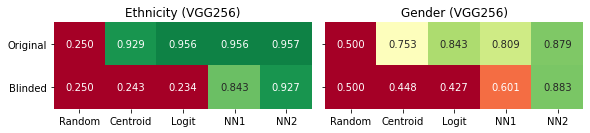

In [91]:
plot_awareness(sdf,'VGG256','256')

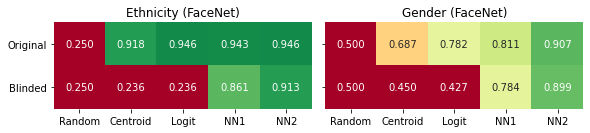

In [224]:
_, df = reader.read('FaceNet')
yr = df.race.cat.codes.values
yg = 1-df.gender.cat.codes.values
ya = df.age.cat.codes.values
df = pd.read_hdf(mystore,'clf_predict_indices_facenet')
sdf = calc_score(df, f1_score, yr, yg, ya)

fig = plot_awareness(sdf,'FaceNet','FaceNet')
fig.savefig('latex/awareness_facenet.eps')

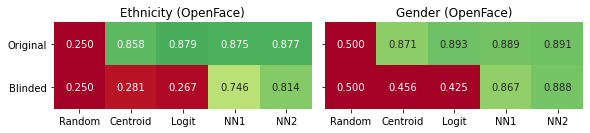

In [93]:
_, df = reader.read('OpenFace')
yr = df.race.cat.codes.values
yg = 1-df.gender.cat.codes.values
ya = df.age.cat.codes.values
df = pd.read_hdf(mystore,'clf_predict_indices_openface')
sdf = calc_score(df, f1_score, yr, yg, ya)

plot_awareness(sdf,'OpenFace','OpenFace')

# Face recognition rate (pair metric)

In [239]:
df = pd.read_hdf(mystore,'pair_predictions')
df.head()

,race,gender,age,label1,label2,subject1,subject2,issame,128-n-e,128-r-e,...,256-n-e,256-r-e,256-r-c,256-g-e,256-g-c,ft-n-e,ft-r-e,ft-r-c,ft-g-e,ft-g-c
0,Caucasian,Female,30-45,Caucasian_027n6t8_0003,Caucasian_027n6t8_0002,Caucasian_027n6t8,Caucasian_027n6t8,1,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,Caucasian,Male,30-45,Caucasian_016lb3_0004,Caucasian_016lb3_0002,Caucasian_016lb3,Caucasian_016lb3,1,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,Caucasian,Male,30-45,Caucasian_02_4qt_0003,Caucasian_02_4qt_0002,Caucasian_02_4qt,Caucasian_02_4qt,1,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,Caucasian,Male,30-45,Caucasian_09g8fj_0003,Caucasian_09g8fj_0001,Caucasian_09g8fj,Caucasian_09g8fj,1,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,Caucasian,Female,30-45,Caucasian_01q3xr_0001,Caucasian_01q3xr_0003,Caucasian_01q3xr,Caucasian_01q3xr,1,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


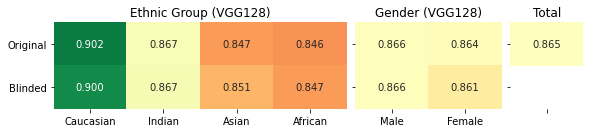

In [240]:
def plot_pairrecrate(df, ncol, rcol, gcol, title, delta=0.03):
    fig, axs = plt.subplots(ncols=3, gridspec_kw={'width_ratios':[4,2,1]}, sharey=True,figsize=(8,2))
    plt.subplots_adjust(top=0.8,bottom=0.2,left=0.08,wspace=0.05,right=1)

    tmp = pd.DataFrame(df.mean()[[ncol]])
    vmin = tmp.values[0]-0.04
    vmax = tmp.values[0]+0.04

    g = sns.heatmap(tmp,cmap='RdYlGn',annot=True,cbar=False,fmt='.3f',vmin=vmin, vmax=vmax,ax=axs[2])
    g.set_title('Total')
    g.set_xticklabels([],rotation=0)
    g.set_yticklabels(['Original','Blinded'],rotation=0)

    tmp = df.groupby(['race']).mean()[[ncol,rcol]].T[reader.race_list]
    g = sns.heatmap(tmp,cmap='RdYlGn',annot=True,cbar=False,fmt='.3f',vmin=vmin, vmax=vmax,ax=axs[0])
    g.set(xlabel=None)
    g.set_title('Ethnic Group ({})'.format(title))
    g.set_yticklabels(['Original','Blinded'],rotation=0)

    tmp = df.groupby(['gender']).mean()[[ncol,gcol]].T[['Male','Female']]
    g = sns.heatmap(tmp,cmap='RdYlGn',annot=True,cbar=False,fmt='.3f',vmin=vmin, vmax=vmax,ax=axs[1])
    g.set(xlabel=None)
    g.set_title('Gender ({})'.format(title))
    g.set_xticklabels(['Male','Female'],rotation=0)
    g.set_yticklabels(['Original','Blinded'],rotation=0)
    return fig

df = pd.read_hdf(mystore,'pair_predictions')
fig = plot_pairrecrate(df,'128-n-e','128-r-e','128-g-e','VGG128')
fig.savefig('latex/pair_recrate_vgg128.eps')

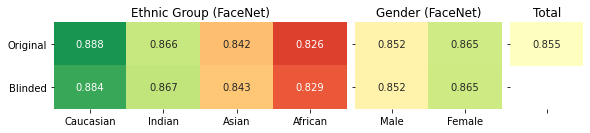

In [247]:
df = pd.read_hdf(mystore,'pair_predictions_facenet')
fig = plot_pairrecrate(df,'FaceNet-n-e','FaceNet-r-e','FaceNet-g-e','FaceNet')
fig.savefig('latex/pair_recrate_facenet.eps')

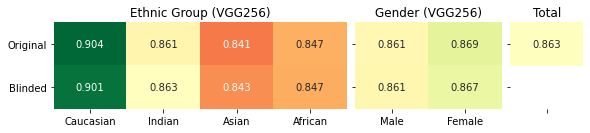

In [246]:
df = pd.read_hdf(mystore,'pair_predictions')
fig = plot_pairrecrate(df,'256-n-e','256-r-e','256-g-e','VGG256')
fig = fig.savefig('latex/pair_recrate_vgg256.eps')

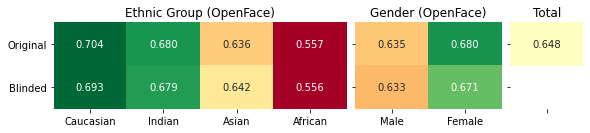

In [243]:
df = pd.read_hdf(mystore,'pair_predictions_openface')
fig = plot_pairrecrate(df,'OpenFace-n-e','OpenFace-r-e','OpenFace-g-e','OpenFace')
fig.savefig('latex/pair_recrate_openface.eps')

# Centroid radii

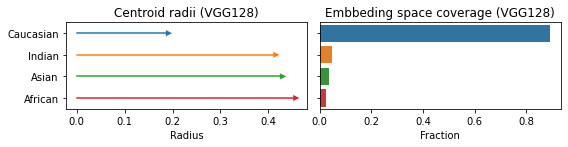

In [229]:
from sklearn.neighbors import NearestCentroid

def centroid_plot(X, y, labels,title, Nr = 100000):
    clf = NearestCentroid()
    clf.fit(X,y)
    Xr = np.random.normal(size=[Nr,clf.centroids_.shape[1]])
    Xr = Xr / np.linalg.norm(Xr, axis=1, keepdims=True)
    ypr = list(clf.predict(Xr))
    df = pd.DataFrame()
    for ir, race in enumerate(labels):
        df.loc[ir,'radius'] = np.linalg.norm(clf.centroids_[ir,:])
        df.loc[ir,'fraction'] = ypr.count(ir)/Nr
    df['label'] = labels
    df2 = pd.concat([df, df.assign(radius=0)],0)
    
    fig, axs = plt.subplots(ncols=2, gridspec_kw={'width_ratios':[1,1]}, sharey=True,figsize=(8,2))
    plt.subplots_adjust(top=0.8,bottom=0.2,left=0.12,wspace=0.05,right=0.98)

    sns.lineplot(data=df2, x='radius', y='label',hue='label',legend=False,ax=axs[0])
    g = sns.scatterplot(data=df, x='radius', y='label',hue='label',legend=False,ax=axs[0],marker='>',s=50)
    g.set(xlabel='Radius')
    g.set(ylabel=None)
    g.set_title('Centroid radii ({})'.format(title))

    g = sns.barplot(data=df,x='fraction',y='label',ax=axs[1])
    g.set(ylabel=None)
    g.set(xlabel='Fraction')
    g.set_title('Embbeding space coverage ({})'.format(title))
    return fig


model = 'VGG128'
X, df = reader.read(model)
yr = df.race.cat.codes.values
fig = centroid_plot(X,yr,reader.race_list,model)
fig.savefig('latex/centroid_plot_vgg128.eps')

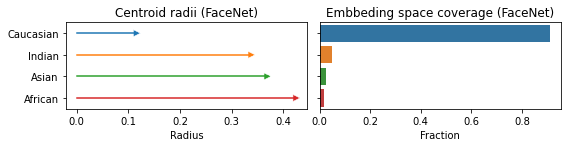

In [230]:
model = 'FaceNet'
X, df = reader.read(model,embeddings_key='embeddings_normed')
yr = df.race.cat.codes.values
fig = centroid_plot(X,yr,reader.race_list,model)
fig.savefig('latex/centroid_plot_facenet.eps')

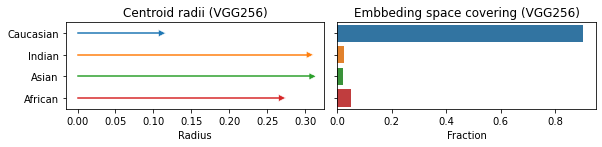

In [172]:
model = 'VGG256'
X, df = reader.read(model)
yr = df.race.cat.codes.values
fig = centroid_plot(X,yr,reader.race_list,model)

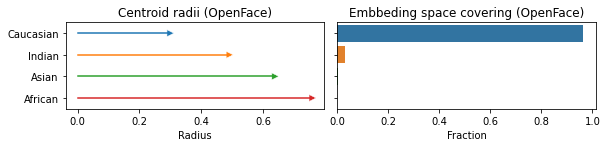

In [173]:
model = 'OpenFace'
X, df = reader.read(model)
yr = df.race.cat.codes.values
fig = centroid_plot(X,yr,reader.race_list,model)

# Plot bad points

In [106]:
tdf =  pd.read_hdf(mystore,'t_SNE_vgg128').join(reader.read('VGG128')[1][['subject','img']])
df = pd.read_hdf(mystore,'pair_predictions') 
for col in ['x','y']:
    df[col] = (tdf.set_index('img').reindex(df.label1)[col].values + tdf.set_index('img').reindex(df.label2)[col].values)/2
df = df.dropna().reset_index(drop=True)
df.head()

,race,gender,age,label1,label2,subject1,subject2,issame,128-n-e,128-r-e,...,256-g-e,256-g-c,ft-n-e,ft-r-e,ft-r-c,ft-g-e,ft-g-c,128-n-e-c,x,y
0,Caucasian,Female,30-45,Caucasian_027n6t8_0003,Caucasian_027n6t8_0002,Caucasian_027n6t8,Caucasian_027n6t8,1,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,True,-22.219135,27.735504
1,Caucasian,Male,30-45,Caucasian_016lb3_0004,Caucasian_016lb3_0002,Caucasian_016lb3,Caucasian_016lb3,1,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,True,-2.754644,-0.186018
2,Caucasian,Male,30-45,Caucasian_02_4qt_0003,Caucasian_02_4qt_0002,Caucasian_02_4qt,Caucasian_02_4qt,1,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,True,-2.230737,-9.204693
3,Caucasian,Male,30-45,Caucasian_09g8fj_0003,Caucasian_09g8fj_0001,Caucasian_09g8fj,Caucasian_09g8fj,1,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,True,16.405148,7.491241
4,Caucasian,Female,30-45,Caucasian_01q3xr_0001,Caucasian_01q3xr_0003,Caucasian_01q3xr,Caucasian_01q3xr,1,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,True,-28.676514,15.798721


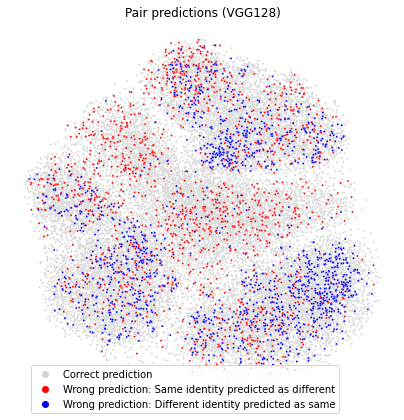

In [108]:
def plot_tSNE_error(df, correct_col, title, same_col = 'issame'):
    fig = plt.figure(figsize=[7,7])
    rec_dict = {1.:'Correct prediction',
                0.5:'Wrong prediction: Same identity predicted as different',
                0:'Wrong prediction: Different identity predicted as same'}
    palette = dict(zip(rec_dict.values(),['lightgrey','red','blue']))
    df['rec_col'] = df[correct_col] + (1-df[correct_col])*df[same_col]/2
    df['label'] = df['rec_col'].apply(lambda x: rec_dict[x])
    g = sns.scatterplot(data=df.sort_values(by='rec_col', ascending=False),
                        x='x',y='y',hue='label',legend=True,s=4, palette=palette)
    plt.title('Pair predictions ({})'.format(title))
    plt.axis('off')
    plt.legend(bbox_to_anchor=(0.85, 0.1), loc=1, borderaxespad=0.)
    plt.show()
    return fig

fig = plot_tSNE_error(df,'128-n-e','VGG128')
fig.savefig("latex/t-SNE_vgg128_errors.png",bbox_inches='tight')

In [109]:
tdf =  pd.read_hdf(mystore,'t_SNE_FaceNet').join(reader.read('FaceNet')[1][['subject','img']])
df = pd.read_hdf(mystore,'pair_predictions_facenet')
for col in ['x','y']:
    df[col] = (tdf.set_index('img').reindex(df.label1)[col].values + tdf.set_index('img').reindex(df.label2)[col].values)/2
df = df.dropna().reset_index(drop=True)

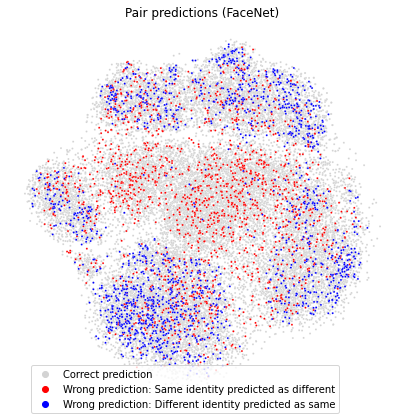

In [110]:
fig = plot_tSNE_error(df,'FaceNet-n-e','FaceNet')
fig.savefig("latex/t-SNE_facenet_errors.png",bbox_inches='tight')

## Error rates as bar Plots

In [42]:
def get_err_rate(key, label, label_order, store=mystore,
                cols = {'128-n-e':'original','128-r-e':'blinded','128-n-e-c':'centroid'}):

    df = (pd.read_hdf(mystore,key).dropna()
          .assign(total='All')
          .rename(columns=cols) )
    
    out = []
    for col in cols.values():
        tmp = (df.groupby([label,'issame',col]).count()['label1']
           .reset_index()
           .rename(columns = {'label1':'N',col:'good'})
           .query('good==0').assign(col=col))
        tmp[label] = pd.Categorical(tmp[label], categories=label_order) 
        out.append(tmp.sort_values(by=label))
    out = pd.concat(out,0)
    
    out['Tot'] = (df.groupby([label]).count()[['label1']]
       .rename(columns = {'label1':'N'})
       .reindex(out[label])
       .N.values)
    out['errrate'] = out.N / out.Tot *100
    out = out.rename(columns={label:'label'})
    out['tot_errrate'] = out.groupby(['label','col']).sum().reindex(out[['label','col']])['errrate'].values

    return out

df = pd.concat([get_err_rate('pair_predictions','total',['All']),
                get_err_rate('pair_predictions','race',reader.race_list),
                get_err_rate('pair_predictions','gender',['Male','Female'],
                             cols = {'128-n-e':'original','128-g-e':'blinded','128-n-e-c':'centroid'}),
                 ],0).reset_index(drop=True)
df.head()

,label,issame,good,N,col,Tot,errrate,tot_errrate
0,All,0,0.0,1516,original,23652,6.409606,13.453408
1,All,1,0.0,1666,original,23652,7.043802,13.453408
2,All,0,0.0,1513,blinded,23652,6.396922,13.381532
3,All,1,0.0,1652,blinded,23652,6.984610,13.381532
4,All,0,0.0,1300,centroid,23652,5.496364,11.474717


In [43]:
df.query("label=='All' & col=='original'").tot_errrate[0]

13.453407745645187

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


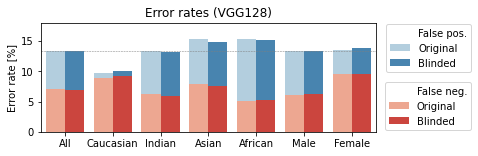

In [44]:
from matplotlib.patches import Rectangle
def plot_error_bar(df, title, legend = True, labels= ['Original','Blinded','Centroid']):
    fig, ax = plt.subplots(figsize=[6,2])
    sel = (df.issame == 1) & (df.col.isin([s.lower() for s in labels]))
    g = sns.barplot(data=df[sel],
                    y='tot_errrate',x='label',hue='col',palette='Blues',ax=ax)
    g = sns.barplot(data=df[sel],
                    y='errrate',x='label',hue='col',palette='Reds',ax=ax)
    extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    h,l = g.get_legend_handles_labels()
    N = len(labels)
    if legend:
        legend1 = g.legend([extra]+h[0:(N+1)],['False pos.']+labels,loc='lower right', bbox_to_anchor=(1.3, 0.5), ncol=1)
        legend2 = g.legend([extra]+h[N:(2*N)],['False neg.']+labels,loc='upper right', bbox_to_anchor=(1.3, 0.5), ncol=1)
        #plt.legend()
        plt.gca().add_artist(legend1)
    else:
        plt.legend([],[], frameon=False)
    g.set(ylabel='Error rate [%]')
    g.set(xlabel=None)
    g.set(ylim=[0,18])
    ax.axhline(df.query("label=='All' & col=='original'").tot_errrate[0], ls='--',color='grey',lw=0.5)
    plt.title('Error rates ({})'.format(title))
    return fig

fig = plot_error_bar(df,'VGG128',labels=['Original','Blinded'])
fig.savefig('latex/error_rate_bars_vgg128_v2.eps',bbox_inches='tight')

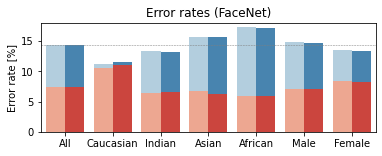

In [45]:
key = 'pair_predictions_facenet'
cols = {'FaceNet-n-e':'original','FaceNet-r-e':'blinded','FaceNet-n-e-c':'centroid'}
cols2 = {'FaceNet-n-e':'original','FaceNet-g-e':'blinded','FaceNet-n-e-c':'centroid'}
df = pd.concat([get_err_rate(key,'total',['All'],cols=cols),
                get_err_rate(key,'race',reader.race_list,cols=cols),
                get_err_rate(key,'gender',['Male','Female'],cols=cols2),
                 ],0).reset_index(drop=True)

fig = plot_error_bar(df,'FaceNet',legend=False,labels=['Original','Blinded'])
fig.savefig('latex/error_rate_bars_facenet_v2.eps',bbox_inches='tight')